# Parameters

ZPGenerator is built to handle components that have many different parameters. This is particularly important once we start building new components and time-dynamic control pulses in a composable way. Let's take a look at the basic methods we can use to modify parameters to manipulate the simulation model.

In [337]:
from zpgenerator import *

Components can have many parameters, and only a few could be relevant for a particular simulation. To see what parameters can be modified for a particular component, we can use the 'parameters' property to get a list of the parameter keys. As an example, let's consider a single photon source created by the Source.fock() method.

In [338]:
source = Source.fock(1)
source.parameters

['decay', 'delay', 'dephasing', 'efficiency', 'resonance']

For a description of what these parameters mean, please see the appropriate section of [Sources](sources.ipynb).

## Default parameters
A component must be instantiated with a set of default parameters, and these can be accessed by the 'default_parameters' property. However, all catalogue components have a set of reasonable default parameters hard-coded so that they function without needing to specify every parameter.

In [339]:
source.default_parameters

{'resonance': 0.0,
 'dephasing': 0.0,
 'delay': 0.0,
 'decay': 1.0,
 'efficiency': 1}

One or more default parameters can be overwritten when creating the object via a factory method. This can be done using the 'parameters' keyword.

In [340]:
source = Source.fock(1, parameters={'efficiency': 0.8})
source.default_parameters

{'resonance': 0.0,
 'dephasing': 0.0,
 'delay': 0.0,
 'decay': 1.0,
 'efficiency': 0.8}

A component's default parameters can also be updated after instantiation using the 'update_default_parameters' method.

In [341]:
source.update_default_parameters(parameters={'delay': 0.5})
source.default_parameters

{'resonance': 0.0,
 'dephasing': 0.0,
 'delay': 0.5,
 'decay': 1.0,
 'efficiency': 0.8}

## Modifying parameters

When properties of the component are simulated, the default parameters will be used automatically. For example, if we want to compute the photon statistics of our source we can use the photon_statistics() method without further specifying any parameters.

In [342]:
source.photon_statistics().display()

Number  | Probability
0       | 0.20000
1       | 0.80000
2       | 0.00000
3       | 0.00000
4       | 0.00000



However, in many cases, we would like to quickly check how the property changes when modifying one or more parameters. This can be done using the 'parameters' keyword for simulations methods, such as the photon_statistics() method.

In [343]:
source.photon_statistics(parameters={'efficiency': 0.5}).display()

Number  | Probability
0       | 0.50000
1       | 0.50000
2       | 0.00000
3       | 0.00000
4       | 0.00000



## Namespace

Often we have multiple subcomponents composed to make a larger component, and these subcomponents may share parameter names. This can lead to unexpected parameter clashes, where a parameter is modified unintentionally. Suppose we want to add loss to our source.

In [344]:
source = Source.fock(1) // Circuit.loss()

If we now look at the parameters, we can see it is the same as before. In addition, the photon statistics give the result without loss because the loss component has a default transmission efficiency of 1.

In [345]:
print(source.parameters)
source.photon_statistics().display()

['decay', 'delay', 'dephasing', 'efficiency', 'resonance']
Number  | Probability
0       | 0.00000
1       | 1.00000
2       | 0.00000
3       | 0.00000
4       | 0.00000



However, if we now simulate the photon statistics for 'efficiency' set to 0.5 we get something unexpected.

In [346]:
source.photon_statistics(parameters={'efficiency': 0.5}).display()

Number  | Probability
0       | 0.75000
1       | 0.25000
2       | 0.00000
3       | 0.00000
4       | 0.00000



The probability of getting a single photon is half of what we expect. This is because modifying the 'efficiency' parameter will modify the efficiency of both the source _and_ the loss component. One solution might be to make sure all components have unique parameter names, but this 'bug' of modifying multiple parameters simultaneously is actually an extremely convenient feature. For example, we may want to modify all the widths of pulses in the same pulse sequence, or modify all the resonances of a group of sources relative to a local oscillator. Thus, the more elegant solution is to ensure that components with clashing parameters are given a unique name. This can be done when instantiating a component using the 'name' keyword. This creates a hierarchy of parameter namespaces that can be manipulated easily to target individual parameters or multiple parameters simultaneously.

In the case above, we are adding a loss component to a Fock source component. This means that the loss component is contained in the source's namespace along with the Fock source's parameters. If we give that loss component a name, we can now target the efficiency of just that subcomponent of the source.

In [347]:
source = Source.fock(1) // Circuit.loss(name='transmission')

Now, we can see that the parameter lists two different efficiencies, one for each named component. The 'transmission' component now has a parameter 'efficiency' delimited by '/'.

In [348]:
source.parameters

['decay',
 'delay',
 'dephasing',
 'efficiency',
 'resonance',
 'transmission/efficiency']

In [349]:
source.photon_statistics(parameters={'transmission/efficiency': 0.5}).display()

Number  | Probability
0       | 0.50000
1       | 0.50000
2       | 0.00000
3       | 0.00000
4       | 0.00000



However, we retain the ability to modify all efficiency parameters simultaneously.

In [350]:
source.photon_statistics(parameters={'efficiency': 0.5}).display()

Number  | Probability
0       | 0.75000
1       | 0.25000
2       | 0.00000
3       | 0.00000
4       | 0.00000



## Advanced Features

There are some advanced features that can be used to modify parameters. To demonstrate these features, we will use the Pulse class, see [Pulses](pulses.ipynb) for more details on how to use the Pulse class.

### Wildcard symbol

To help target particular subspaces, one can use the wildcard symbol '*' to represent any namespace. For example, let's make a pulse sequence that contains two subsequences.

In [351]:
sequence = Pulse()
subsequence_1 = Pulse(name='excitation')
subsequence_2 = Pulse(name='control')

sequence.add(subsequence_1)
sequence.add(subsequence_2)

subsequence_1.add(Pulse.gaussian(parameters={'delay': 0}), name='pulse 1')
subsequence_1.add(Pulse.gaussian(parameters={'delay': 2}), name='pulse 2')
subsequence_2.add(Pulse.gaussian(parameters={'delay': 1}), name='pulse 1')

This sequence contains 3 Gaussian pulses organized into 'excitation' and 'control' subsequences. In the 'excitation' subsequence, we have two pulses 'pulse 1' and 'pulse 2'. In the 'control' subsequence we have just one pulse 'pulse 1'. Listing the parameters, we can see that already the number of parameters is significant.

['control/pulse 1/area', 'control/pulse 1/delay', 'control/pulse 1/detuning', 'control/pulse 1/phase', 'control/pulse 1/width', 'control/pulse 1/window', 'excitation/pulse 1/area', 'excitation/pulse 1/delay', 'excitation/pulse 1/detuning', 'excitation/pulse 1/phase', 'excitation/pulse 1/width', 'excitation/pulse 1/window', 'excitation/pulse 2/area', 'excitation/pulse 2/delay', 'excitation/pulse 2/detuning', 'excitation/pulse 2/phase', 'excitation/pulse 2/width', 'excitation/pulse 2/window']


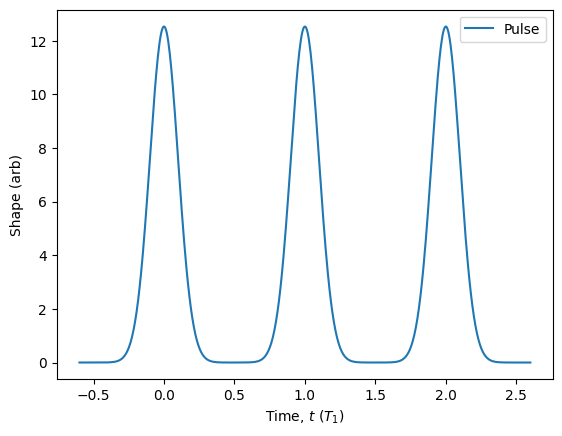

In [352]:
print(sequence.parameters)
sequence.plot().show()

Suppose we want to modify the 'width' of all pulses in the 'excitation' subsequence. To do this, we can use the wildcard '*' symbol in place of either 'pulse 1' or 'pulse 2'.

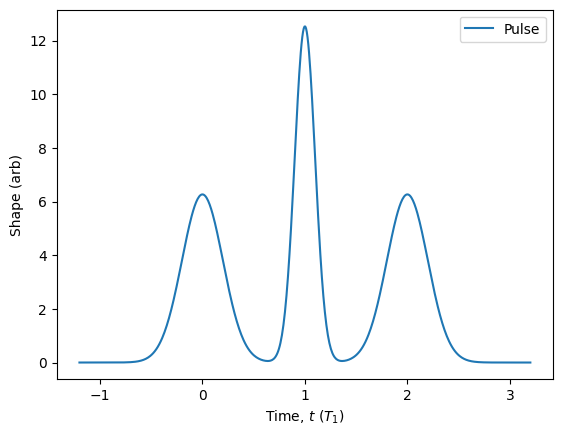

In [353]:
sequence.plot(parameters={'excitation/*/width': 0.2}).show()

### Renaming

For convenience, sometimes it is useful to customise the names of catalogue components.

In [354]:
source = Source.fock(1)
source.parameters

['decay', 'delay', 'dephasing', 'efficiency', 'resonance']

In [355]:
source.rename_parameter('efficiency', 'collection')
source.parameters

['collection', 'decay', 'delay', 'dephasing', 'resonance']

What this really does is give the component a rule to take any parameter named 'collection' and modify it to 'efficiency' before passing it to any functions or subcomponents. Unfortunately, this means it cannot be used to avoid parameter clashes. Instead, it is always recommended to use better namespace organization to fix paramaeter clashes.

### Parameter functions

Often we can have that some parameters depend on other parameters, or we wish to modify parameters automatically to perform unit conversions. This can be accomplished by creating parameter functions. There are two main types of parameter functions, a default parameter function and an overwrite parameter function. A parameter function is simply a function that takes a dictionary of parameters and returns a new dictionary, perhaps with some custom modifications to the keys and values.

##### Default parameter function

The default parameter function will take incoming parameters and set the default value of another parameter. That means, if the value of the output parameter is set when simulating the component, it will be overwritten.

In [356]:
pulse = Pulse() // Pulse.gaussian()
pulse.default_parameters

{'width': 0.1,
 'area': 3.141592653589793,
 'delay': 0,
 'detuning': 0,
 'phase': 0,
 'window': 6}

In [357]:
pulse.create_default_parameter_function(lambda args: {'width': args['delay']/10},
                                        parameters={'delay': 0})

With this parameter function, we have tied the 'width' parameter by default to the 'delay' parameter. Since the 'delay' is set to 0 by default, we can see that it the default 'width' also 0.

In [358]:
print(pulse.default_parameters)

{'width': 0.0, 'area': 3.141592653589793, 'delay': 0, 'detuning': 0, 'phase': 0, 'window': 6}


If we now update the value of 'delay', we will also update the value of 'width'.

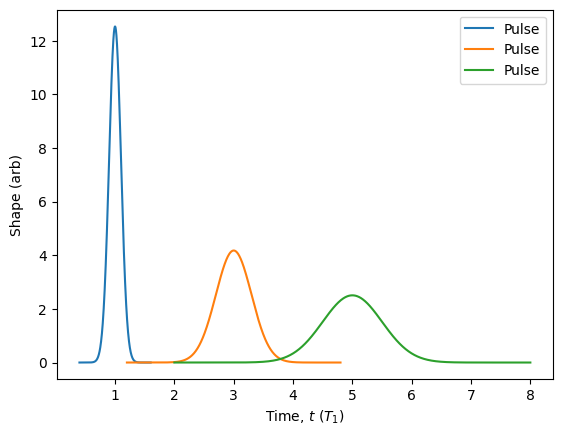

In [359]:
pulse.plot(parameters={'delay': 1})
pulse.plot(parameters={'delay': 3})
pulse.plot(parameters={'delay': 5}).show()

However, because we created a default parameter function, we can always overwrite the 'width' manually.

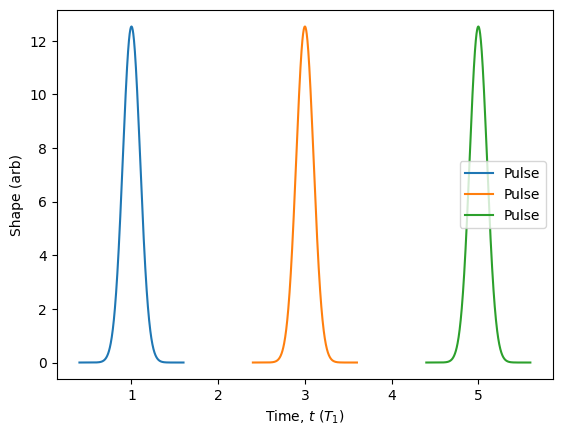

In [360]:
pulse.plot(parameters={'delay': 1, 'width': 0.1})
pulse.plot(parameters={'delay': 3, 'width': 0.1})
pulse.plot(parameters={'delay': 5, 'width': 0.1}).show()

##### Overwrite parameter function

The overwrite parameter function is used to take incoming parameters and overwrite the dictionary with new parameters computed by the function. That means, if the value of the output parameter cannot be modified and must always be influenced through its arguments.

In [361]:
pulse = Pulse() // Pulse.gaussian()
pulse.create_overwrite_parameter_function(lambda args: {'width': args['delay']/10},
                                          parameters={'delay': 0})
print(pulse.default_parameters)

{'width': 0.0, 'area': 3.141592653589793, 'delay': 0, 'detuning': 0, 'phase': 0, 'window': 6}


We can see that the initial behaviour is the same as for the default parameter function.

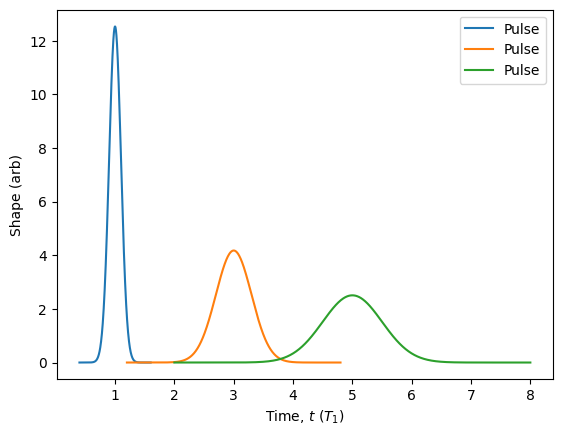

In [362]:
pulse.plot(parameters={'delay': 1})
pulse.plot(parameters={'delay': 3})
pulse.plot(parameters={'delay': 5}).show()

But now we cannot overwrite the value computed by the overwrite parameter function.

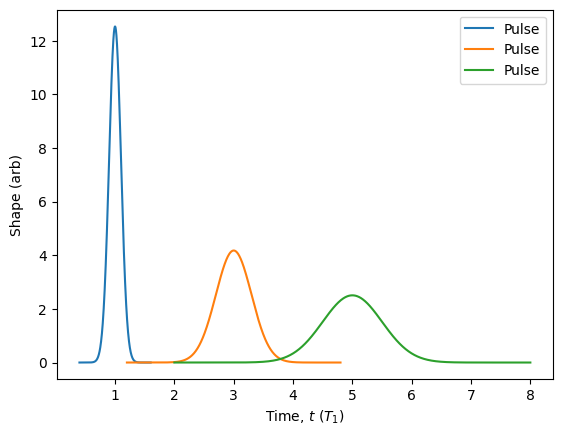

In [363]:
pulse.plot(parameters={'delay': 1, 'width': 0.1})
pulse.plot(parameters={'delay': 3, 'width': 0.1})
pulse.plot(parameters={'delay': 5, 'width': 0.1}).show()